# Indice

* [Introduzione](#Introduzione)
* [Step 1 - EDA](#Step1)
    - [Osservazione 1.1](#Oss1.1)
    - [Osservazione 1.2](#Oss1.2)
    - [Osservazione 1.3](#Oss1.3)
    - [Osservazione 1.4](#Oss1.4)
    - [Osservazione 1.5](#Oss1.5)
    - [Osservazione 1.6](#Oss1.6)
    - [Osservazione 1.7](#Oss1.7)
* [Step 2 - Feature Importance](#Step2)
    - [Osservazione 2.1](#Oss2.1)
    - [Lasso Features](#lasso)
    - [RF Features](#rafo)
    - [Osservazione 2.2](#Oss2.2)
* [Step 3 - Predizione](#Step3)
    - [Support Vector Regressor](#SVR)
    - [Osservazione 3.1](#Oss3.1)
    - [Osservazione 3.2](#Oss3.2)
    - [RF vs Ridge](#RF)
    - [Osservazione 3.3](#Oss3.3)
    - [Gradient Boosting Regressor](#GBR)
* [Conclusione - Parte 1](#Con1)
* [Step 4 - What if?](#Step4)
* [Conclusione - Parte 2](#Con2)
* [Idee iniziali vs Considerazioni finali](#epilogo)

## Introduzione

Il dataset che studieremo riguarda degli studenti portoghesi: tra le varie caratteristiche troveremo il consumo di alcol settimanale (diviso in giorni lavorativi e non) ed i voti di portoghese divisi per periodo (G1, G2, G3).

Il motivo per cui si stia studiando proprio il Portogallo potrebbe essere il seguent: dal [link](https://www.federvini.it/studi-e-ricerche-cat/3557-eurostat,-italia-terza-in-ue-per-consumo-di-alcol-quotidiano) si legge "*L'assunzione giornaliera di alcol è stata la più frequente in Portogallo, con un quinto (20,7%) della popolazione che consuma alcol ogni giorno*". Per sottolineare, dunque, l'importanza di un uso moderato di alcolici studiando proprio uno dei paesi che ne fa più uso!

Il nostro obiettivo sarà capire quali (e quanto) caratteristiche influiscono maggiormente sul voto finale. Per farlo procederemo in vari step:
1. EDA ed ipotesi iniziali
2. Feature Importance - per fare un filtro su cosa è utile e cosa no
3. Predizione dei voti finali, analisi dei risultati, scelta del miglior modello (e conseguentemente di features)
4. Confronto con un'analisi "grezza"

Gli iperparametri dei vari modelli saranno selezionati tramite la RandomizedSearchCV, che a differenza della GridSearchCV, non va a fare il confronto su ogni singolo valore, riducendo così la mole di calcolo e la velocità di esecuzione!

## Step 1 - EDA
<a id="Step1"></a>

In [1]:
# Importo i pacchetti (EDA)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
plt.style.use('fivethirtyeight')

# Importo i pacchetti (ML)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Importo i dati e leggiamo le prime 5 righe
df = pd.read_csv('student-por.csv')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [4]:
# Ci sono dei null value?
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [5]:
# Controlliamo quali valori possono assumere alcune categorie
{col: df[col].unique().tolist() for col in df.select_dtypes(include = 'object').columns}

{'school': ['GP', 'MS'],
 'sex': ['F', 'M'],
 'address': ['U', 'R'],
 'famsize': ['GT3', 'LE3'],
 'Pstatus': ['A', 'T'],
 'Mjob': ['at_home', 'health', 'other', 'services', 'teacher'],
 'Fjob': ['teacher', 'other', 'services', 'health', 'at_home'],
 'reason': ['course', 'other', 'home', 'reputation'],
 'guardian': ['mother', 'father', 'other'],
 'schoolsup': ['yes', 'no'],
 'famsup': ['no', 'yes'],
 'paid': ['no', 'yes'],
 'activities': ['no', 'yes'],
 'nursery': ['yes', 'no'],
 'higher': ['yes', 'no'],
 'internet': ['no', 'yes'],
 'romantic': ['no', 'yes']}

### Osservazione 1.1
<a id="Oss1.1"></a>

* Abbiamo un dataset di 649 studenti;
* Ci sono 33 features, di cui la maggior parte categoriche. Alcune variabili *sembrano* numeriche, ma in realtà non lo sono. Per esempio: Medu - mother's education (0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education);
* Vi sono solamente 5 variabili numeriche: age, absences, e grades (G1, G2, G3);
* Non abbiamo missing values.

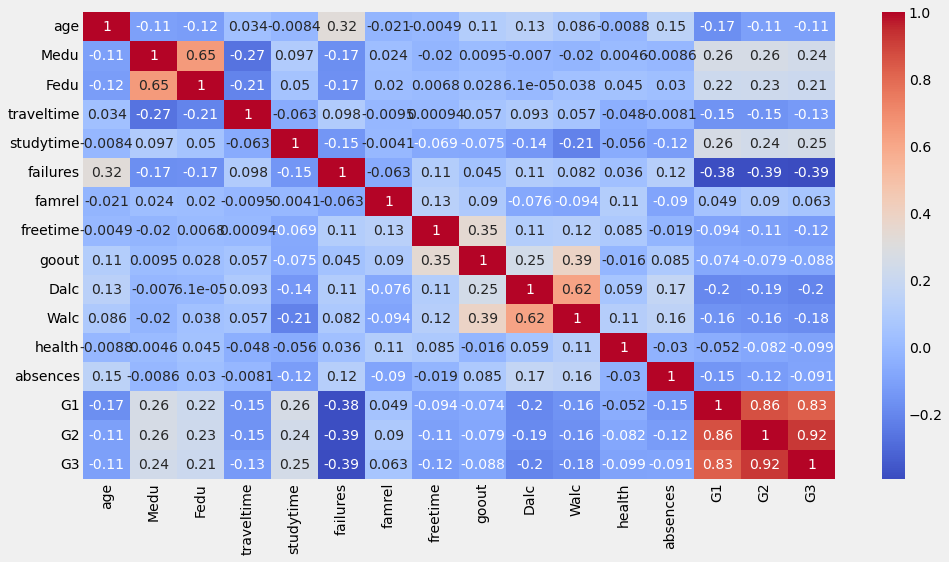

In [6]:
# Correlazione tra le variabili?
plt.figure(figsize= (15,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.show()

Vi è una forte correlazione tra G1, G2 e G3: potremmo ipotizzare che l'andamento dei voti rimanga "coerente" nel corso dell'anno.

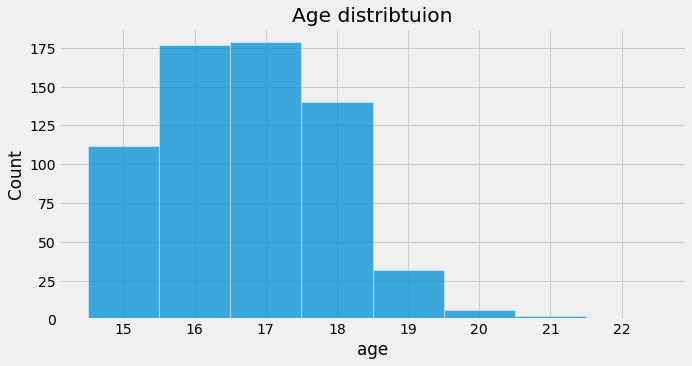

In [7]:
# Distribuzione dell'età
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='age', bins=8, discrete=True)
plt.title('Age distribtuion')
plt.show()

In [8]:
# Quanti outliers?
df[df['age'] >= 20].groupby('age').size()

age
20    6
21    2
22    1
dtype: int64

### Osservazione 1.2
<a id="Oss1.2"></a>

La scuola secondaria in Portogallo ha una durata di 3 anni ([link](https://www.scholaro.com/pro/Countries/Portugal/Education-System)) , ovvero dai 15 ai 18 anni di età, possiamo quindi considerare gli studenti dai 20 anni in su come *outliers*. 

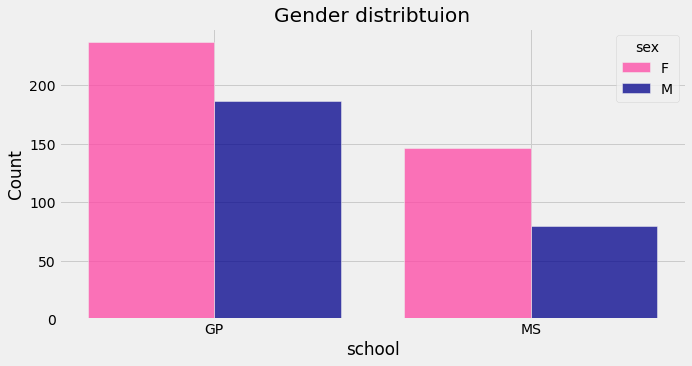

In [9]:
# Come si suddividono raazzi e ragazze nelle due scuole?
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='school', hue='sex', palette=['#FE46A5', '#00008B'], multiple="dodge", shrink=.8)
plt.title('Gender distribtuion')
plt.show()

In [10]:
# Percentuale suddivisione delle due scuole
pd.concat([df['school'].value_counts().to_frame(), df['school'].value_counts(normalize=True).to_frame()], axis=1)

,school,school
GP,423,0.651772
MS,226,0.348228


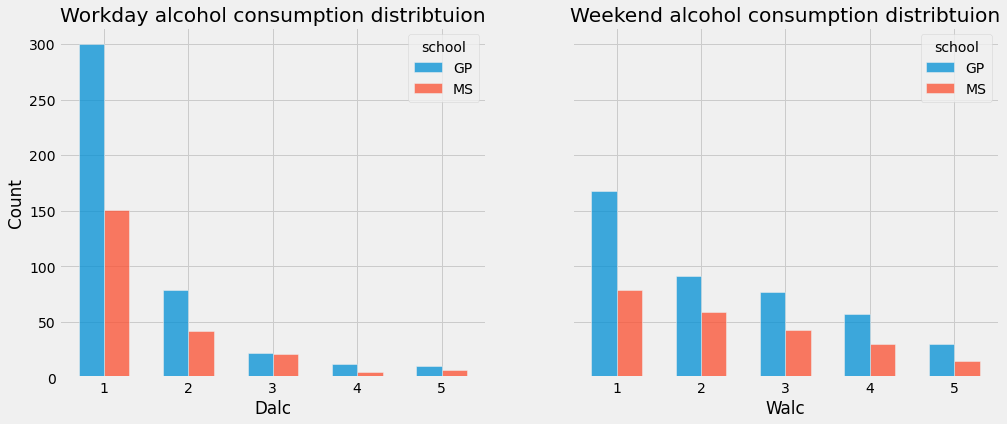

In [11]:
# Confornto consumo di alcol - scuole
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 6))

sns.histplot(data=df, x='Dalc', hue='school', multiple="dodge", shrink=.6, discrete=True, ax=ax[0])
ax[0].set_title('Workday alcohol consumption distribtuion')


sns.histplot(data=df, x='Walc', hue='school', multiple="dodge", shrink=.6, discrete=True, ax=ax[1])
ax[1].set_title('Weekend alcohol consumption distribtuion')

plt.show()

In [12]:
df2 = df.groupby(['Dalc', 'school']).size().reset_index(name='Ratio')
a = df2.groupby('school')['Ratio'].transform('sum')
df2['Ratio'] = df2['Ratio'].div(a)
df2

,Dalc,school,Ratio
0,1,GP,0.709220
1,1,MS,0.668142
2,2,GP,0.186761
3,2,MS,0.185841
4,3,GP,0.052009
5,3,MS,0.092920
6,4,GP,0.028369
7,4,MS,0.022124
8,5,GP,0.023641
9,5,MS,0.030973


In [13]:
df2 = df.groupby(['Walc', 'school']).size().reset_index(name='Ratio')
a = df2.groupby('school')['Ratio'].transform('sum')
df2['Ratio'] = df2['Ratio'].div(a)
df2

,Walc,school,Ratio
0,1,GP,0.397163
1,1,MS,0.349558
2,2,GP,0.215130
3,2,MS,0.261062
4,3,GP,0.182033
5,3,MS,0.190265
6,4,GP,0.134752
7,4,MS,0.132743
8,5,GP,0.070922
9,5,MS,0.066372


<a id="Oss1.3"></a>
### Osservazione 1.3


Il consumo di alcol - in percentuale - è equamente distribuito nelle due scuole. Frequentare una o l'altra sembra dunque non influire.

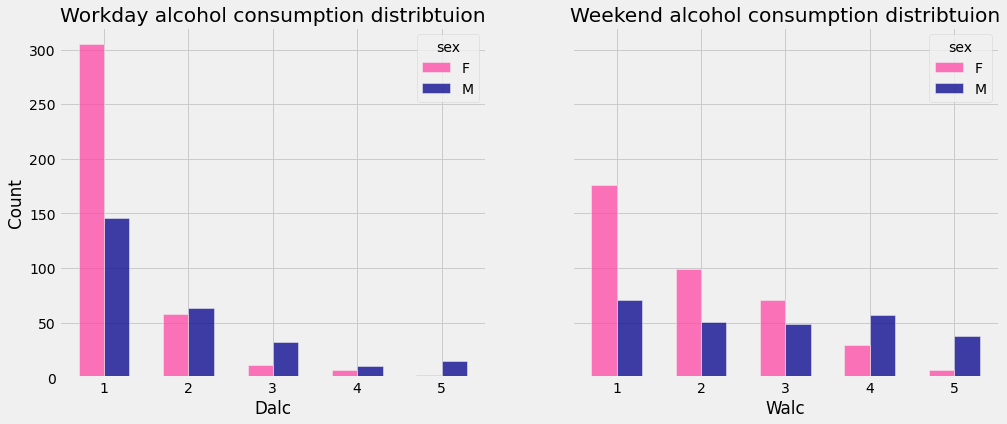

In [14]:
# Confornto consumo di alcol - genere
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 6))

sns.histplot(data=df, x='Dalc', hue='sex', palette=['#FE46A5', '#00008B'], multiple="dodge", shrink=.6, discrete=True, ax=ax[0])
ax[0].set_title('Workday alcohol consumption distribtuion')


sns.histplot(data=df, x='Walc', hue='sex', multiple="dodge", palette=['#FE46A5', '#00008B'], shrink=.6, discrete=True, ax=ax[1])
ax[1].set_title('Weekend alcohol consumption distribtuion')

plt.show()

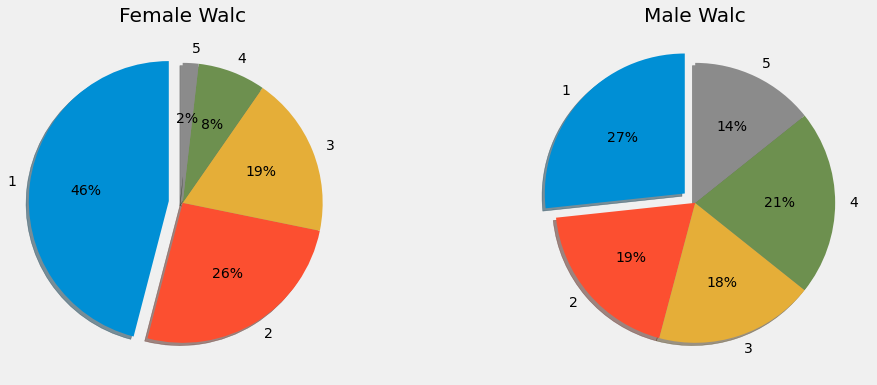

In [15]:
explode = (0.1, 0, 0, 0, 0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

pie = df.groupby(['Walc', 'sex']).size().reset_index(name='total')

pie[pie['sex'] == "F"].plot(kind='pie', y='total', labels=pie.Walc.unique(), autopct='%1.0f%%' 
                            ,title='Female Walc', ylabel='', explode=explode
                            ,startangle=90, shadow=True, legend=False
                            ,ax=ax[0])

pie[pie['sex'] == "M"].plot(kind='pie', y='total', labels=pie.Walc.unique(), autopct='%1.0f%%' 
                            ,title='Male Walc', ylabel='', explode=explode
                            ,startangle=90, shadow=True, legend=False
                            ,ax=ax[1])

plt.show()

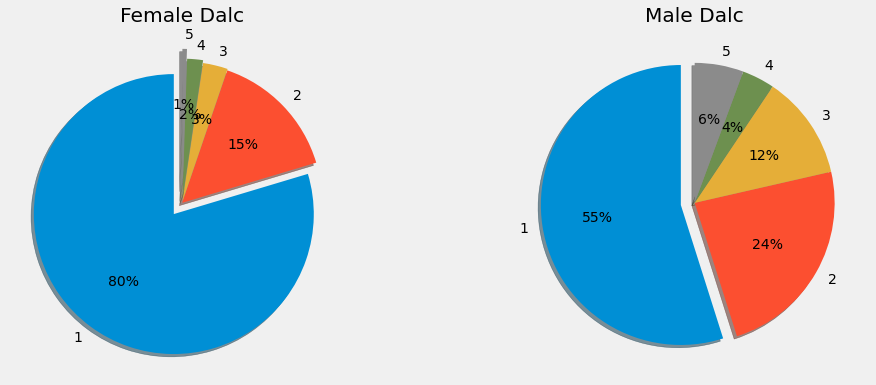

In [16]:
explode_f = (0.1, 0, 0.01, 0.03, 0.1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

pie2 = df.groupby(['Dalc', 'sex']).size().reset_index(name='total')
pie2[pie2['sex'] == "F"].plot(kind='pie', y='total', labels=pie2.Dalc.unique(), autopct='%1.0f%%' 
                            ,title='Female Dalc', ylabel='', explode=explode_f
                            ,startangle=90, shadow=True, legend=False
                            ,ax=ax[0])

pie2[pie2['sex'] == "M"].plot(kind='pie', y='total', labels=pie2.Dalc.unique(), autopct='%1.0f%%' 
                            ,title='Male Dalc', ylabel='', explode=explode
                            ,startangle=90, shadow=True, legend=False
                            ,ax=ax[1])

plt.show()

### Osservazione 1.4
<a id="Oss1.4"></a>

Qui la situazione cambia radicalmente. La percentuale di ragazzi che consuma alcol è di molto superiore - sia nel weekend sia nei giorni lavorativi - a quella delle ragazze.

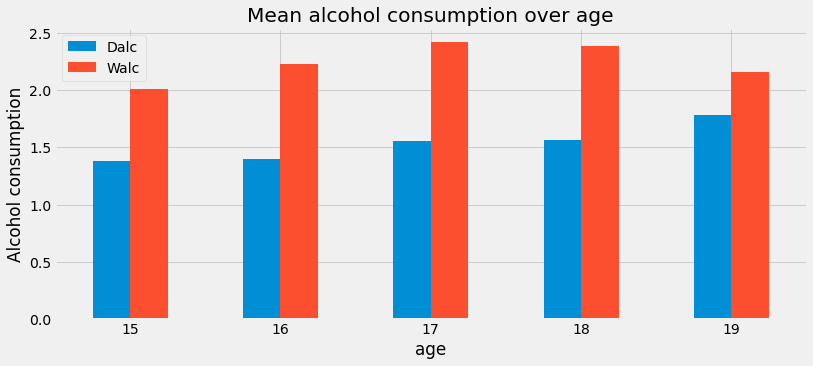

In [17]:
# Consumo di alcol in media al crescere dell'età
# Tengo fuori gli outliers
df[df['age'] <= 19].groupby('age')[['Dalc', 'Walc']].mean().plot(kind='bar', figsize=(12,5))
plt.ylabel('Alcohol consumption')
plt.xticks(rotation=0)
plt.title('Mean alcohol consumption over age')
plt.show()

In [18]:
# Esamino gli outliers a parte
df[df['age'] >= 20][['sex', 'age', 'Dalc', 'Walc']]

,sex,age,Dalc,Walc
279,M,22,5,5
299,F,20,1,2
351,M,20,1,1
407,F,21,1,1
413,M,21,5,2
414,F,20,1,3
421,F,20,1,1
506,F,20,2,4
574,M,20,2,4


In [19]:
# Quanti studenti bevono solo nel weekend?
df[df['Dalc'] == 1]['Walc'].value_counts(normalize=True)

1    0.534368
2    0.250554
3    0.141907
4    0.062084
5    0.011086
Name: Walc, dtype: float64

### Osservazione 1.5
<a id="Oss1.5"></a>

L'età minima per bere alcolici in Portogallo è di 16 anni ([link](https://www.termometropolitico.it/1216235_leta-minima-per-bere-in-europa-dove-sono-piu-permissivi-la-mappa.html)), risulta quindi naturale che a partire da questa età il consumo di alcol aumenti in media.
Possiamo notare, inoltre, come la percentuale di chi beve solo durante il weekend sia quasi il 47%.

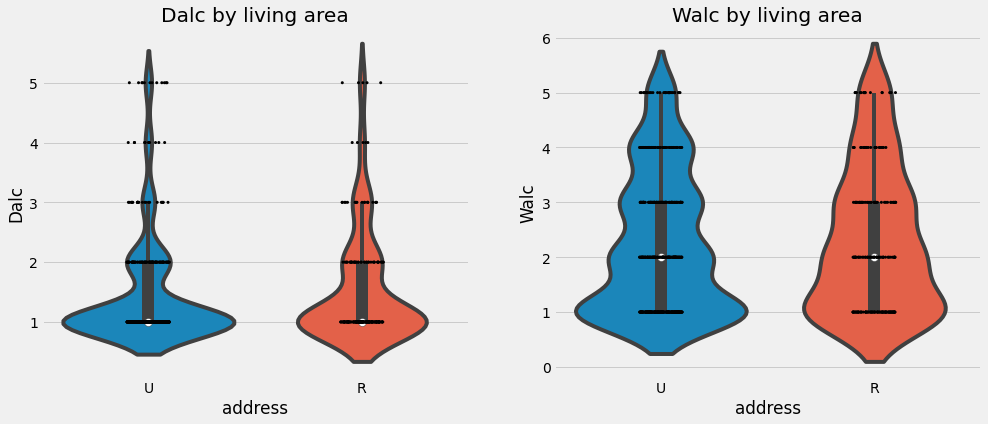

In [20]:
# Distribuzione consumo alcol in base all'area di residenza
# U - Urban; R - Rural
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.violinplot(data=df, x='address', y='Dalc', ax=ax[0])
sns.stripplot(data=df, x='address', y='Dalc', color="k", size=3, ax=ax[0])
ax[0].set_title('Dalc by living area')

sns.violinplot(data=df, x='address', y='Walc', ax=ax[1]) 
sns.stripplot(data=df, x='address', y='Walc', color="k", size=3, ax=ax[1])
ax[1].set_title('Walc by living area')

plt.show()

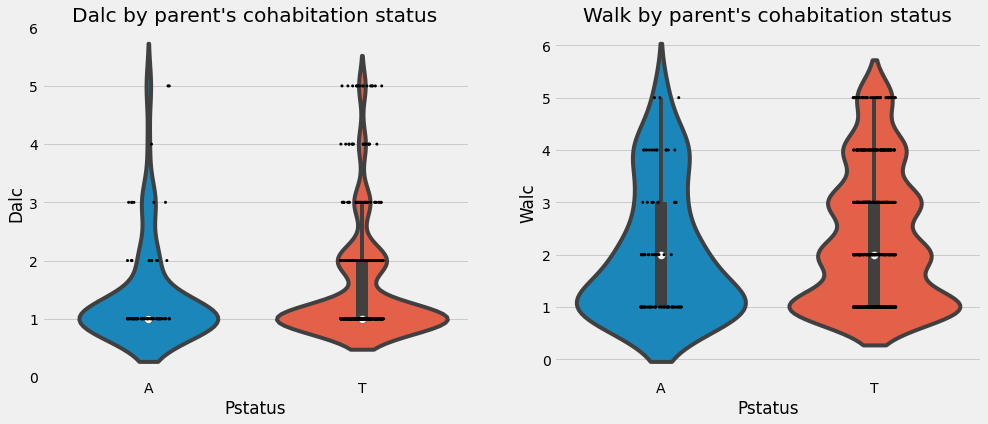

In [21]:
# Distribuzione consumo alcol in base allo stato di abitazione dei propri genitori
# A - Apart; T - Together
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.violinplot(data=df, x='Pstatus', y='Dalc', ax=ax[0]) 
sns.stripplot(data=df, x='Pstatus', y='Dalc', color="k", size=3, ax=ax[0])
ax[0].set_title('Dalc by parent\'s cohabitation status')

sns.violinplot(data=df, x='Pstatus', y='Walc', ax=ax[1]) 
sns.stripplot(data=df, x='Pstatus', y='Walc', color="k", size=3, ax=ax[1])
ax[1].set_title('Walk by parent\'s cohabitation status')

plt.show()

### Osservazione 1.6
<a id="Oss1.6"></a>

Sembra che chi viva in zone rurali tenda a bere leggermente di più, mentre vivere con entrambi i genitori sembra ridurre il consumo di alcol durante i giorni lavorativi.

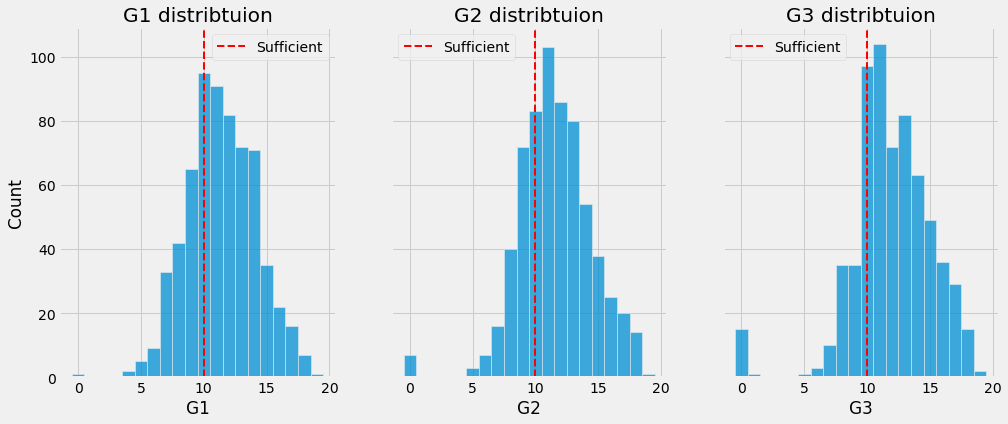

In [22]:
# Distribuzione dei voti per i 3 periodi, con confronto per la sufficienza
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 6))

sns.histplot(data=df, x="G1", discrete=True, ax=ax[0])
ax[0].set_title('G1 distribtuion')

sns.histplot(data=df, x="G2", discrete=True, ax=ax[1])
ax[1].set_title('G2 distribtuion')

sns.histplot(data=df, x="G3", discrete=True, ax=ax[2])
ax[2].set_title('G3 distribtuion')

for i in range(3):
    ax[i].axvline(10, label='Sufficient', color='red', linestyle='--', linewidth=2)
    ax[i].legend()


plt.show()

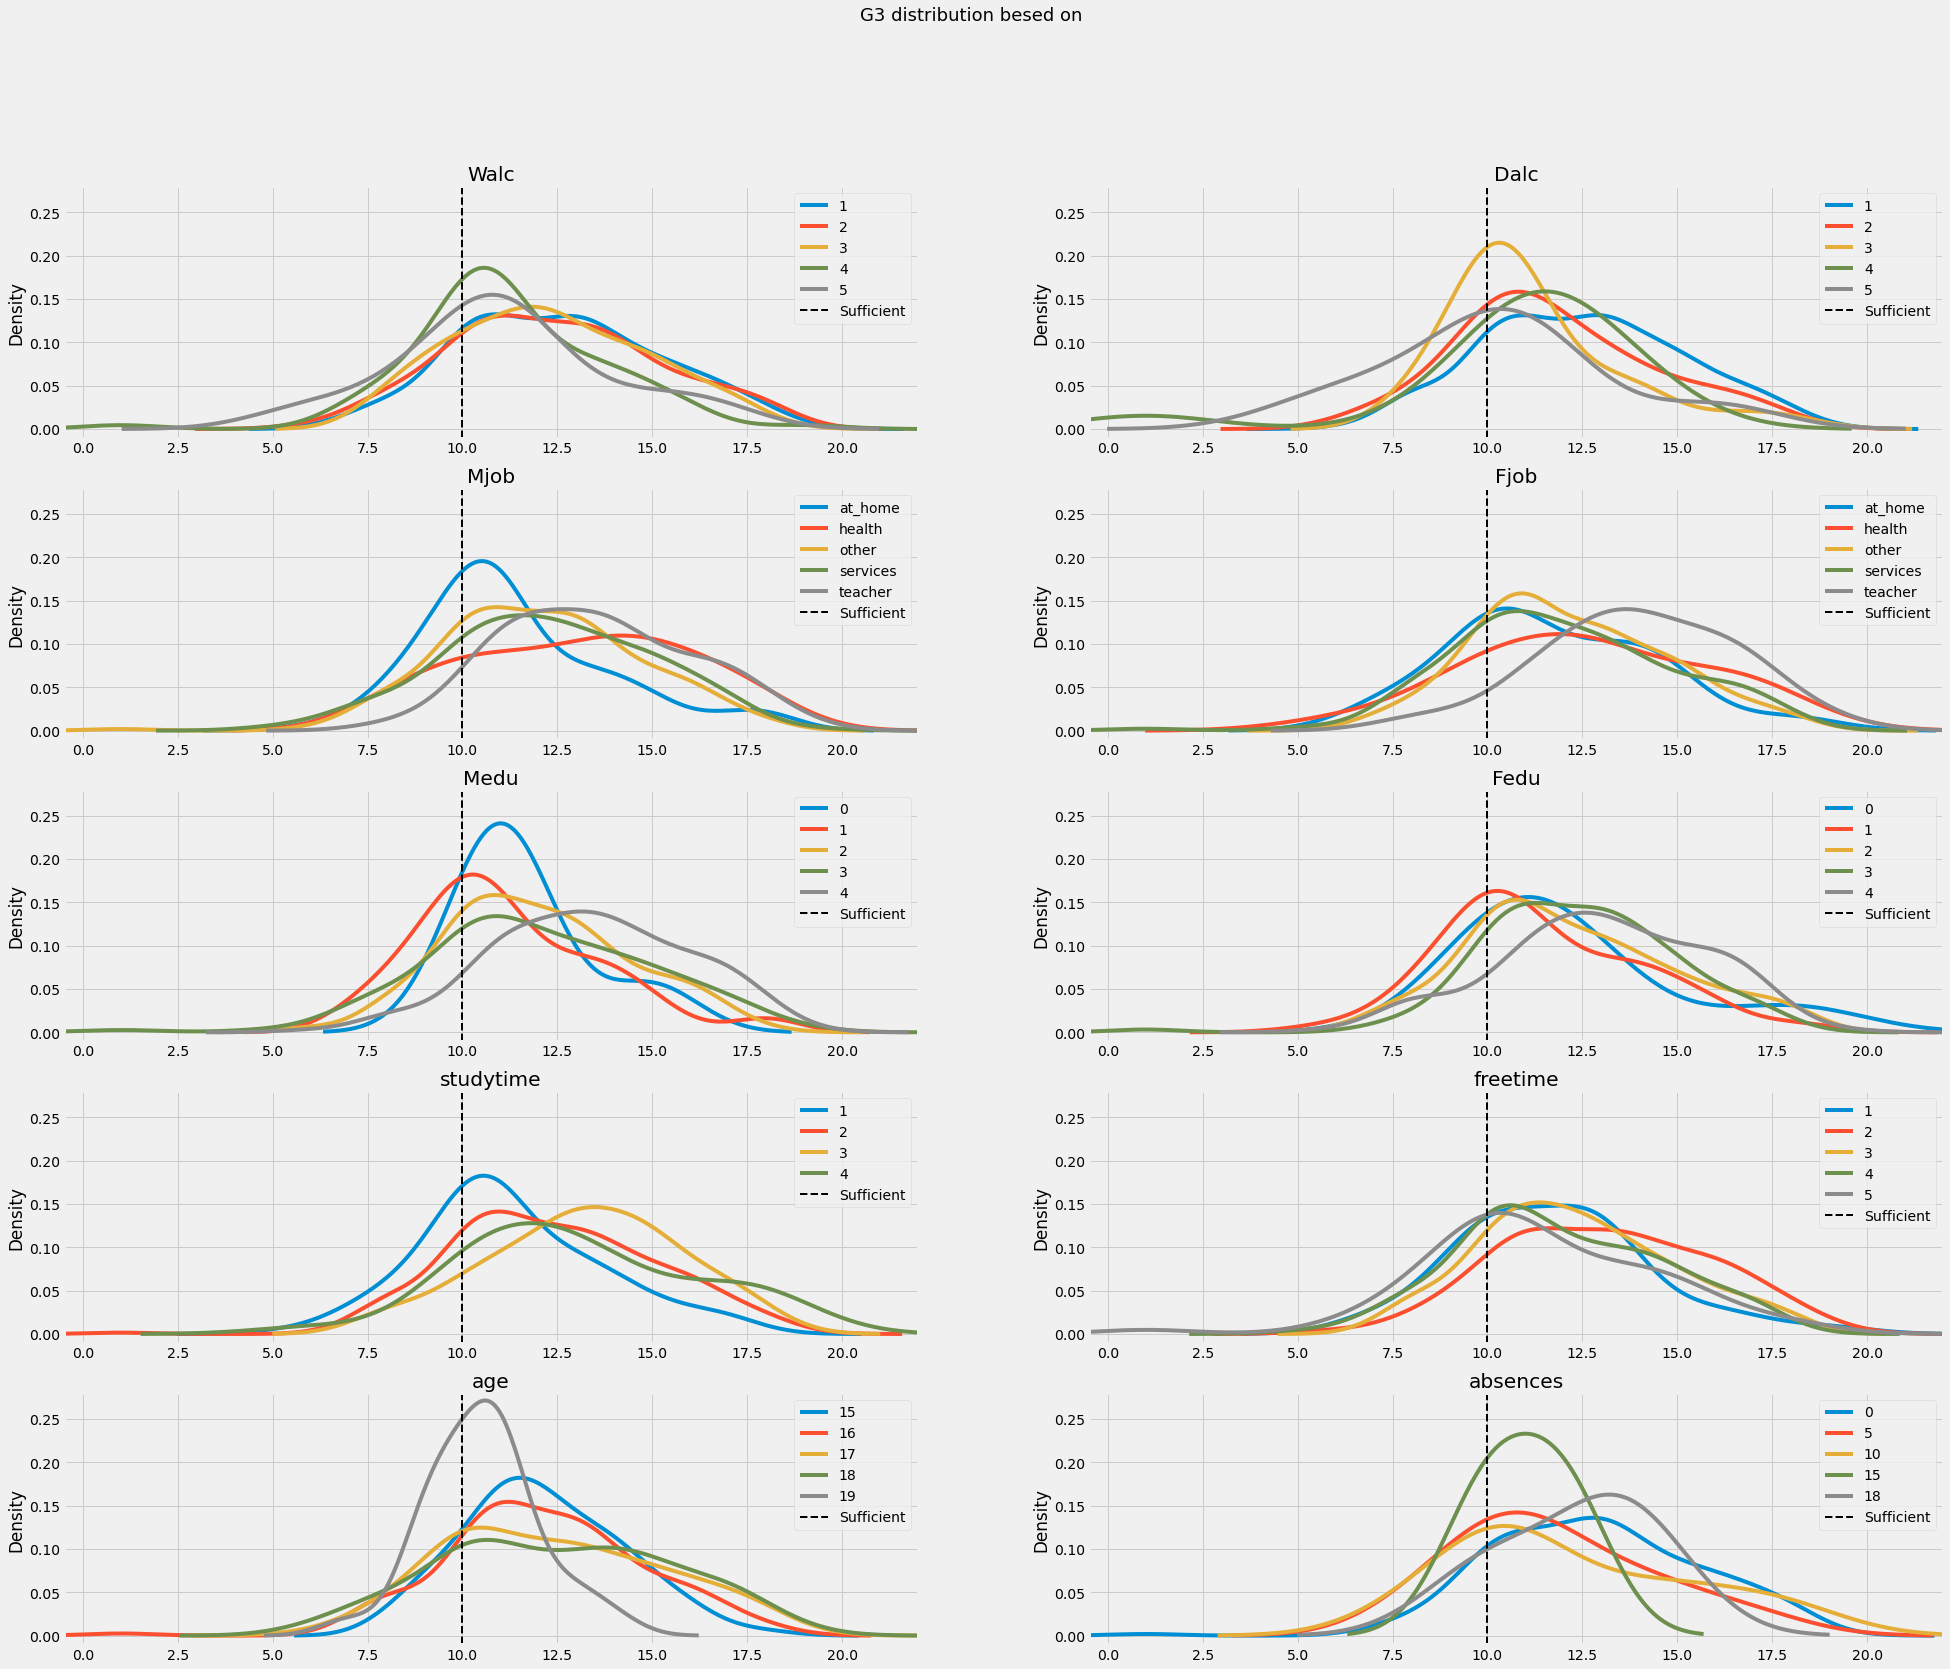

In [23]:
# Distribuzione di G3 in generale rispetto a più variabili categoriche
plt.figure(figsize=(30, 25))
plt.suptitle("G3 distribution besed on", fontsize=18)

category = ['Walc', 'Dalc', 'Mjob', 'Fjob', 'Medu', 'Fedu', 'studytime', 'freetime', 'age', 'absences']

# for loop per creare un subplot per ogni categoria
for n, name in enumerate(category):
    ax = plt.subplot(5, 2, n + 1)

    # raggruppo i dati ed assegno l'etichetta da stampare nella leggenda
    for cat, grouped_data in df.groupby(name):
        if (name == 'age'):
            if (cat <= 19):
                gdata = grouped_data[grouped_data['G3'] != 0]['G3']        
                sns.kdeplot(gdata, label=cat)
        elif (name == 'absences'):
            if ((cat == 0) | (cat == 5) | (cat == 10) | (cat == 15) | (cat == 18)):
                gdata = grouped_data[grouped_data['G3'] != 0]['G3']        
                sns.kdeplot(gdata, label=cat)
        else:
            gdata = grouped_data[grouped_data['G3'] != 0]['G3']        
            sns.kdeplot(gdata, label=cat)

        # aggiusto un pò di parametri estetici
        ax.set_ylim([-0.01,0.28])
        ax.set_xlim([-0.5,22])
        ax.set_ylabel=("")
        ax.set_title(name)
        ax.set_xlabel("")
    # retta della sufficienza per poter fare meglio i confronti
    ax.axvline(10, label='Sufficient', color='k', linestyle='--', linewidth=2)
    ax.legend()

<a id="Oss1.7"></a>
### Osservazione 1.7


* Il voto minimo in Portogallo è 1, dunque i voti pari a 0 è possibile si riferiscano a studenti che hanno abbandonato il percorso di studi o semplicemente a dei dati mancanti;
* Il numero di insufficienti diminuisce con l'avazanzare del tempo (G1 - G2 - G3);
* Bere duranti i giorni lavorativi sembra avere maggior effetto rispetto al weekend. Tuttavia, il consumo eccessivo (4 - 5) abbassa la media voti indipendentemente dal tipo di giorno;
* Per quanto riguarda il tipo di lavoro dei genitori sembra essere maggiormente impattante quando:
    - la madre è a casa;
    - il padre fa l'insegnante;
* Per quanto riguarda il livello di istruzione dei genitori: 
    - non sempre un "maggior livello" implica una media più alta (es: il picco si sposta verso sinistra per i livelli da 0 ad 1); 
    - in generale, avere dei genitori molto istruiti (livello 4) alza decisamente la media voti;
* Il tempo di studio non sembra essere così decisivo, indice del fatto che conta anche la qualità e non solo il tempo! La quantità di tempo libero disponibile non sortisce - quasi - alcun effetto sull'andamento dei voti;
* L'età è un fattore delicato: di fatto gli studenti dai 19 anni in su sono stati bocciati almeno una volta - tolti rari casi - ciò vuol dire che non ci si può aspettare da loro medie altissime;
* Non sempre un numero maggiore di assenze comporta voti peggiori: in generale non sembra un buon parametro per predire il voto finale di uno studente.

--------------------------

<a id="Step2"></a>
## Step 2 - Feature Importance


Dopo questa prima analisi preliminare, proviamo a cercare quali features impattano maggiromente il voto finale.
Le tecniche che useremo sono la *Lasso Regularization* e la *Random Forest Regression*.

In [24]:
# Elimino gli outliers che ci farebbero commettere troppi errori!
df_no_outliers = df[(df['G3'] != 0) & (df['age'] < 20)].copy()

In [25]:
# Esaminiamo prima gli studenti con G3 pari a 0, vediamone le caratteristiche principali
df[(df['G3'] == 0)][['Walc', 'Dalc', 'Mjob', 'Fjob', 'Medu', 'Fedu', 
                     'studytime', 'freetime', 'higher', 'age', 'sex', 
                     'absences', 'G1', 'G2']]

,Walc,Dalc,Mjob,Fjob,Medu,Fedu,studytime,freetime,higher,age,sex,absences,G1,G2
163,5,2,other,other,1,1,1,3,no,18,M,0,11,9
440,5,4,at_home,services,1,1,2,4,yes,16,M,0,7,0
519,1,1,other,services,2,1,2,2,yes,16,M,0,8,7
563,3,2,other,other,2,2,1,2,yes,17,M,0,7,0
567,2,2,services,other,3,2,1,3,no,18,M,0,4,0
583,1,1,other,other,2,2,1,5,no,18,F,0,8,6
586,3,1,teacher,services,4,2,2,5,yes,17,F,0,8,8
597,1,1,at_home,other,2,2,2,3,yes,18,F,0,9,0
603,1,1,teacher,other,4,2,2,3,yes,18,F,0,5,0
605,3,2,at_home,services,1,1,1,5,no,19,F,0,5,0


<a id="Oss2.1"></a>
### Osservazione 2.1

Supponiamo per un attimo che un voto pari a 0 sia dovuto all'abbandono degli studi:

* Il consumo di alcol è medio-alto: soltanto 4 studenti su 15 non consumano alcol e di questi 4 tre sono ragazze;
* Solo uno studente su 15 raggiunge la sufficienza nel primo periodo. Nel secondo periodo non solo nessuno di questi raggiugne la sufficienza ma sono presenti già diversi valori pari a 0;
* Le assenze sono tutte pari a 0;
* Il livello di istruzione dei genitori è basso, fatta eccezione per una studentessa con Medu e Fedu pari a 4 (ed Fjob = teacher!) ma con un consumo di alcol nei giorni lavorativi pari a 4;
* Il tempo dedicato allo studio è molto basso, complice forse della volontà di non voler continuare a studiare;
* La volontà di proseguire con studi successivi (higher) presenta diversi "yes". Avendo a disposizione i voti solo di una materia, potremmo non sapere se questi studenti sono interessati a studiare tutt'altro una volta usciti dalle superiori; o magari hanno interessi più legati al mondo dello sport... le possibilità sono infinite e non possiamo certo giudicare le persone in base ad un numero (anche se è quello che facciamo!).

In [26]:
# Divido features e target
features_imp = df_no_outliers.copy().drop(['G1', 'G2', 'G3'], axis=1)
target_imp = df_no_outliers.copy()['G3']

print(features_imp.shape)
print(target_imp.shape)

(625, 30)
(625,)


In [27]:
# Scalo le variabili numeriche (tolti i voti rimangono solo age e absences) tramite StandardSacler:
# facciamo in modo che abbiano media pari a 0 e varianza pari a 1!
scaler_num = StandardScaler()
features_imp[['age', 'absences']] = scaler_num.fit_transform(features_imp[['age', 'absences']])

# One-hot-encoding per il resto delle variabili categoriche
ohe_columns = []
for col in features_imp.columns:
    if col not in ['age', 'absences']:
        ohe_columns.append(col)
        
features_imp = pd.get_dummies(features_imp, columns=ohe_columns)

features_imp.head()

,age,absences,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
0,1.178636,0.069205,1,0,1,0,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0
1,0.295366,-0.365501,1,0,1,0,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0
2,-1.471176,0.503912,1,0,1,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0
3,-1.471176,-0.800208,1,0,1,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
4,-0.587905,-0.800208,1,0,1,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1


Usiamo una regolarizzazione Lasso per capire quale feature siano più importanti per lo studio del voto finale. 

L'iperparametro che vogliamo validare è $\alpha$: l'obiettivo della Lasso è minimizzare la somma dei quadrati dei residui più una quantità che dipende da tale $\alpha$. Il risultato è che le features meno importanti avranno un coefficiente che tende a 0.

In [28]:
# Scelgo un insieme di parametri da validare
param = {'alpha': np.arange(0.01, 2, 0.01)}
# Randomized 
lasso = Lasso(random_state=0)
regr = RandomizedSearchCV(lasso, param, random_state=0, scoring='neg_root_mean_squared_error')
search = regr.fit(features_imp, target_imp)
search.best_params_

{'alpha': 0.060000000000000005}

In [29]:
# Creo il modello con alpha ottimale
lasso = Lasso(alpha=0.06, random_state=0)
lasso.fit(features_imp, target_imp)
# Lista di features con coefficiente pari a 0
delete_in_what_if = []
for i, col in enumerate(features_imp.columns):
    if lasso.coef_[i] == 0:
        delete_in_what_if.append(col)

In [30]:
# Creo un 'mini-DataFrame' con features e relativi pesi 
feature_importances_lr_coef = pd.concat([pd.Series(features_imp.columns, name='features'), 
                                         pd.Series(lasso.coef_, name='weights')],
                                        axis=1)
# Non ci interessa il segno - vogliamo capire quali sono i più grandi in modulo
feature_importances_lr_coef['weights'] = abs(feature_importances_lr_coef['weights'])
feature_importances_lr_coef = feature_importances_lr_coef.sort_values(by='weights', ascending=False).reset_index(drop=True)

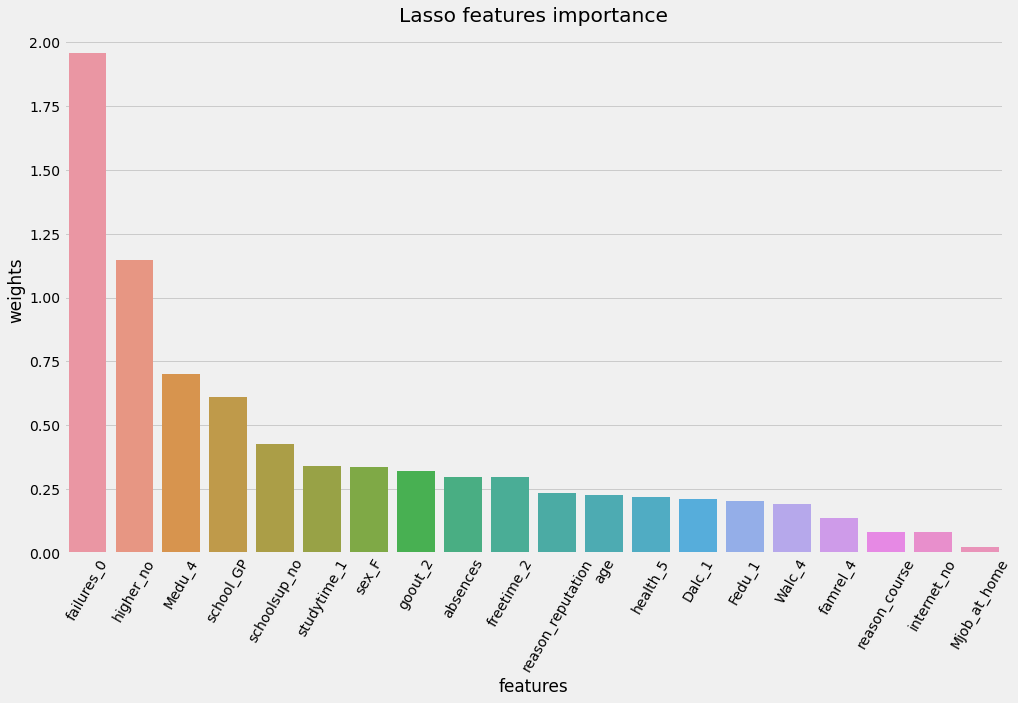

In [31]:
# Rappresento graficamente le 20 features più importanti
plt.figure(figsize=(15,9))
sns.barplot(data=feature_importances_lr_coef[:20], x='features', y='weights')
plt.xticks(rotation=60)
plt.title('Lasso features importance')
plt.show()

<a id="lasso"></a>
### Lasso Features

Le features più importanti - tramite Lasso - risultano essere:

1. failures - numero di debiti lasciati;
2. higher - volontà di proseguire gli studi dopo le superiori;
3. Medu - livello di istruzione della madre;
4. school - quale scuola frequenta: GP/MS;
5. schoolsup - supporto extra-scolastico;
6. studytime - tempo dedicato allo studio durante la settimana;
7. sex - genere;
8. goout - frequenza di uscite con gli amici;
9. absences - numero di assenze;
10. freetime - tempo libero dopo la scuola;
11. reason - motivo per cui si è scelto una determinata scuola;
12. age - età degli studenti;
13. health - stato di salute attuale;
14. **Dalc** - assunzione di alcol durante i giorni lavorativi;
15. Fedu - livello di istruzione del padre;
16. **Walc** - assunzione di alcol durante il weekend;
17. famrel - qualità dei rapporti con la famiglia;
18. internet - accesso ad internet a casa.

La categoria Mjob risulta essere molto vicina a 0 (ed anche le categorie diverse da "at home" hanno coefficiente pari a 0).

---------------

Come contro-prova, vediamo che risultati ci fornisce la Random Forest Regression. Iperparametri:
* n_estimators: numero di Decision Tree da costruire e validare (tramite squared_error di default). Di fatto la Random Forest altro non è che l'iterazione di diversi DT (tramite 'bagging' dei dati);
* max_depth: massima profondità di ciascun albero. Più è piccolo meno complesso saranno i nostri alberi;
* min_samples_split: numero minimo di dati prima di poter dividere un nodo all'interno di un albero;
* max_features: numero massiamo di features da considerare (in questo caso massimo 30).

In [32]:
# Scelgo un insieme di parametri da validare
parameters = {'max_depth' :  np.arange(8, 20, 1),
              'n_estimators' : np.arange(200, 400, 10),
              'max_features' : np.arange(5, 30, 5),
              'min_samples_split' : np.arange(2, 10, 2)}
# Randomized 
rf = RandomizedSearchCV(RandomForestRegressor(), parameters, random_state=0, scoring='neg_root_mean_squared_error')
search = rf.fit(features_imp, target_imp)
search.best_params_

{'n_estimators': 330,
 'min_samples_split': 6,
 'max_features': 25,
 'max_depth': 18}

In [33]:
# Creo il modello ottimale
regressor_rf = search.best_estimator_
regressor_rf.fit(features_imp, target_imp)

RandomForestRegressor(max_depth=18, max_features=25, min_samples_split=6,
                      n_estimators=330)

In [34]:
# Creo un 'mini-DataFrame' con features e relativi pesi
feature_importances_rf = pd.concat([pd.Series(features_imp.columns, name='features'), 
                                    pd.Series(regressor_rf.feature_importances_, name='importance')],
                                    axis=1).sort_values(by='importance', ascending=False).reset_index(drop=True)

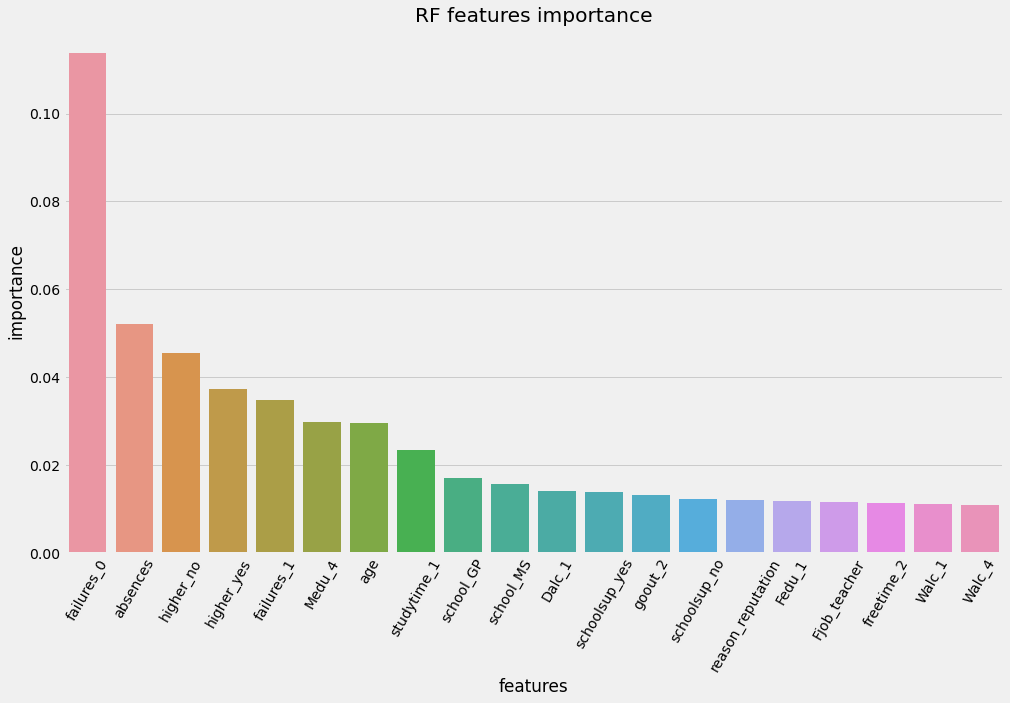

In [35]:
# Rappresento graficamente le 20 features più importanti
plt.figure(figsize=(15,9))
sns.barplot(data=feature_importances_rf[:20], x='features', y='importance')
plt.xticks(rotation=60)
plt.title('RF features importance')
plt.show()

<a id="rafo"></a>
### RF Features

Le features più importanti - tramite RF - risultano essere:

1. failures - numero di debiti lasciati;
2. absences - numero di assenze;
3. higher - volontà di proseguire gli studi dopo le superiori;
4. Medu - livello di istruzione della madre;
5. age - età degli studenti;
6. studytime - tempo dedicato allo studio durante la settimana;
7. school - quale scuola frequenta: GP/MS;
8. goout - frequenza di uscite con gli amici;
8. **Dalc** - assunzione di alcol durante i giorni lavorativi;
9. reason - motivo per cui si è scelto una determinata scuola;
10. Fedu - livello di istruzione del padre; 
11. schoolsup - supporto extra-scolastico;
12. freetime - tempo libero dopo la scuola;
13. **Walc** - assunzione di alcol durante il weekend;
14. sex - genere.

<a id="Oss2.2"></a>
### Osservazione 2.2


* I due modelli differiscono sia per quantità sia per scelta delle features;
* Ho scelto come score la 'neg_root_mean_squared_error' in quanto vorremmo che le nostre previsioni siano - in media - il più vicino possibile ai dati reali;
* Il numero di features si è (quasi) dimezzato con entrambi i metodi.

In [36]:
# Lista delle categorie più importanti per Lasso
lasso_impo = ['failures', 'higher', 'school', 'schoolsup', 'sex', 'Medu', 'Dalc', 'Walc', 'health', 'studytime', 
              'goout', 'Fedu', 'freetime', 'internet', 'reason', 'absences', 'age', 'famrel']
# 'Ripulisco' i dati
to_delete = []

for col in df.columns:
    if col not in lasso_impo:
        to_delete.append(col)

features_lasso = df_no_outliers.copy().drop(columns=to_delete, axis=1)


print(features_lasso.shape)

(625, 18)


In [37]:
# Scalo le variabili numeriche (tolti i voti rimangono solo age e absences) tramite StandardSacler:
# facciamo in modo che abbiano media pari a 0 e varianza pari a 1!
scaler_num = StandardScaler()
features_lasso[['age', 'absences']] = scaler_num.fit_transform(features_lasso[['age', 'absences']])

# One-hot-encoding per le variabili categoriche
ohe_columns = []
for col in features_lasso.columns:
    if col not in ['age', 'absences']:
        ohe_columns.append(col)
        
features_lasso = pd.get_dummies(features_lasso, columns=ohe_columns)

features_lasso.head()

,age,absences,school_GP,school_MS,sex_F,sex_M,Medu_0,Medu_1,Medu_2,Medu_3,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
0,1.178636,0.069205,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0.295366,-0.365501,1,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,-1.471176,0.503912,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,-1.471176,-0.800208,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,-0.587905,-0.800208,1,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1


In [38]:
# Lista delle features più importanti per Random Forest
rf_impo = ['failures', 'higher', 'school', 'schoolsup', 'sex', 'Medu', 'Dalc', 'Walc', 'studytime', 
            'goout', 'Fedu', 'absences', 'reason', 'age', 'freetime']
# 'Ripulisco' i dati
to_delete = []

for col in df.columns:
    if col not in rf_impo:
        to_delete.append(col)

features_rf = df_no_outliers.copy().drop(columns=to_delete, axis=1)


print(features_rf.shape)

(625, 15)


In [39]:
# Scalo le variabili numeriche (tolti i voti rimangono solo age e absences) tramite StandardSacler:
# facciamo in modo che abbiano media pari a 0 e varianza pari a 1!
scaler_num = StandardScaler()
features_rf[['age', 'absences']] = scaler_num.fit_transform(features_rf[['age', 'absences']])

# One-hot-encoding per il resto delle variabili categoriche
ohe_columns = []
for col in features_rf.columns:
    if col not in ['age', 'absences']:
        ohe_columns.append(col)
        
features_rf = pd.get_dummies(features_rf, columns=ohe_columns)

features_rf.head()

,age,absences,school_GP,school_MS,sex_F,sex_M,Medu_0,Medu_1,Medu_2,Medu_3,...,Dalc_1,Dalc_2,Dalc_3,Dalc_4,Dalc_5,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5
0,1.178636,0.069205,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0.295366,-0.365501,1,0,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
2,-1.471176,0.503912,1,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
3,-1.471176,-0.800208,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,-0.587905,-0.800208,1,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


<a id="Step3"></a>
## Step 3 - Predizione

In [40]:
# Splitto i dati in train e test rispettivamente per Lasso e RF

# Lasso: L - features; m - target.
L_train, L_test, m_train, m_test = train_test_split(features_lasso, target_imp, random_state=10)

# RF: R - features; s - target.
R_train, R_test, s_train, s_test = train_test_split(features_rf, target_imp, random_state=10)

for split in [L_train, L_test, m_train, m_test, R_train, R_test, s_train, s_test]:
    print(split.shape)

(468, 64)
(157, 64)
(468,)
(157,)
(468, 52)
(157, 52)
(468,)
(157,)


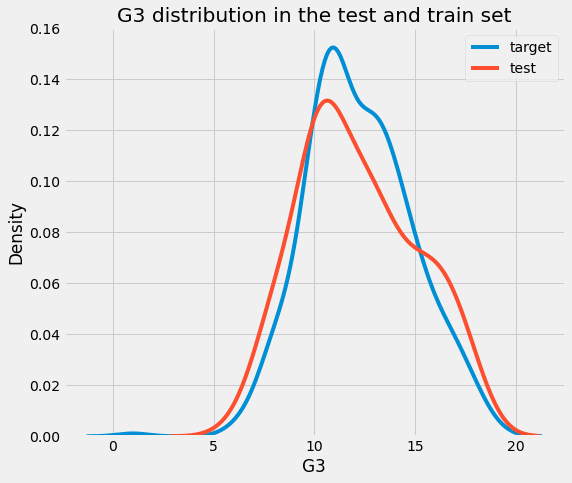

In [41]:
# Controllo che train e test abbiano più o meno la stessa distribuzione
plt.figure(figsize=(8,7))
sns.kdeplot(m_train, label='target')
sns.kdeplot(m_test, label='test')
plt.title('G3 distribution in the test and train set')
plt.legend()
plt.show()

In [42]:
# E media simile
print('train mean value:', m_train.mean())
print('test mean value:', m_test.mean())

train mean value: 12.215811965811966
test mean value: 12.171974522292993


<a id="SVR"></a>
### Support Vector Regressor


Come primo modello testiamo il SVR. Iperparametri:
* C: aggiunge una penalità per ogni dato predetto erroneamente;
* $\varepsilon$: margine di quanto "permissivo" è il nostro errore;
* $\gamma$: controlla l'influenza di ciascun dato a seconda della sua distanza dal *decision boundary*.

In [43]:
# Questa tabella ci tornerà utile per il "confrontone" finale
table = {"Model": [], "MAE": [], "RMSE": []}

# Un'utile funzione che richiameremo più volte!
def print_error(model, test, real_values, model_name):
    """a quick function that prints MAE, RMSE
       it also add relative value to the table 
    """
    pred = model.predict(test)
    print(f"MAE: {mean_absolute_error(pred, real_values)}, RMSE: {mean_squared_error(pred, real_values)**0.5}")
    table["Model"].append(model_name)
    table["MAE"].append(mean_absolute_error(pred, real_values))
    table["RMSE"].append(mean_squared_error(pred, real_values)**0.5)

In [44]:
# Scelgo un insieme di parametri da validare
parameters = {'C' :  np.arange(5, 300, 1),
              'epsilon': np.arange(0.01, 5, 0.01),
              'gamma' : np.arange(0.01, 100, 0.01)}             
# Randomized SVR - Lasso features
svr1 = RandomizedSearchCV(SVR(), parameters, n_iter=150, random_state=0, scoring='neg_root_mean_squared_error')

# Addestro prima con le Lasso features
search_lasso = svr1.fit(L_train, m_train)
search_lasso.best_params_

{'gamma': 0.8200000000000001, 'epsilon': 1.1300000000000001, 'C': 279}

In [45]:
# Randomized SVR - RF features
svr2 = RandomizedSearchCV(SVR(), parameters, n_iter=150, random_state=0, scoring='neg_root_mean_squared_error')

# Poi con le RF features
search_rf = svr2.fit(R_train, s_train)
search_rf.best_params_

{'gamma': 0.8200000000000001, 'epsilon': 1.1300000000000001, 'C': 279}

In [46]:
# Alleno i due modelli con i rispettivi dati
svr_lasso = search_lasso.best_estimator_
svr_lasso.fit(L_train, m_train)

svr_rf = search_rf.best_estimator_
svr_rf.fit(R_train, s_train)
# Confronto errori
print_error(svr_lasso, L_test, m_test, 'SVR - Lasso Features')
print_error(svr_rf, R_test, s_test, 'SVR - RF Features')

MAE: 2.4322406980793705, RMSE: 2.880181117094895
MAE: 2.421194523095865, RMSE: 2.8683789675740328


### Osservazione 3.1
<a id="Oss3.1"></a>

I risultati degli errori sono molto simili, sembra dunque che la divisione in due dataset non abbia sortito un gran effetto in questo caso.

--------------------------

Poiché sarebbe "difficile" fare un grafico in 30 dimensioni, per avere un'idea graficamente sulla bontà delle nostre previsioni ciò che faremo è:
* Assegnare all'asse X i valori reali;
* All'asse Y i valori del modello;
* Scatterplot e confronto.

Così facendo, la "correttezza" si misurerà dalla distanza che ciascun punto avrà dalla bisettrice (ovvero: y=x, retta dove starebbero tutti i punti se valori predetti e reali coincidessero).

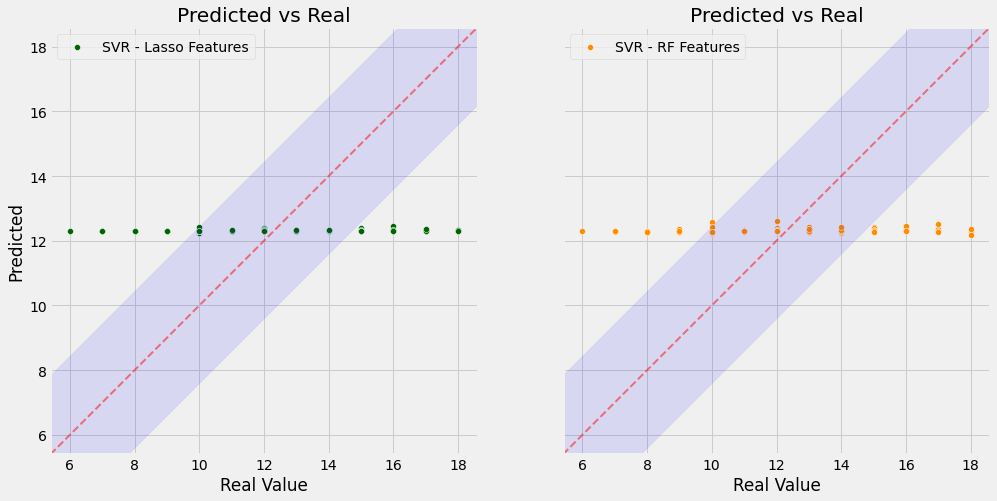

In [47]:
pred1 = svr_lasso.predict(L_test)
pred2 = svr_rf.predict(R_test)
# Scelgo il minor MAE
mae = mean_absolute_error(pred2, s_test)

# Scatterplot delle due predizioni
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,12))
sns.scatterplot(x=m_test, y=pred1, color="darkgreen", label="SVR - Lasso Features", ax=ax[0])
sns.scatterplot(x=s_test, y=pred2, color="darkorange", label="SVR - RF Features", ax=ax[1])
# Confronto con la retta y=x
for i in (0,1):
    lims = [np.min([ax[i].get_xlim(), ax[i].get_ylim()]), np.max([ax[i].get_xlim(), ax[i].get_ylim()])]
# Faccio un "fill" dell'area compresa tra +-MAE
    lims_shift_dx = [
    np.min([ax[i].get_xlim(), ax[i].get_ylim()])+mae,  
    np.max([ax[i].get_xlim(), ax[i].get_ylim()])+mae,  
    ]

    lims_shift_sx = [
    np.min([ax[i].get_xlim(), ax[i].get_ylim()])-mae,  
    np.max([ax[i].get_xlim(), ax[i].get_ylim()])-mae,  
    ]


    ax[i].plot(lims, lims, color='red', linewidth=2, alpha=0.5, linestyle='--')
    ax[i].fill_between(lims, lims_shift_sx, lims_shift_dx, edgecolor='none',
                     color='blue', alpha=0.1)
    ax[i].set_aspect('equal')
    ax[i].set_xlim(lims)
    ax[i].set_ylim(lims)
    ax[i].set_ylabel("Predicted")
    ax[i].set_xlabel("Real Value")
    ax[i].set_title("Predicted vs Real")

plt.show()

<a id="Oss3.2"></a>
### Osservazione 3.2


Come possiamo notare, tutti i valori predetti stazionano tra 12 e 13 a prescindere da quale sia il voto reale. Non è per neinte una buon metodo di predizione!

----------
<a id="RF"></a>
### RF vs Ridge


Studiamo invece il comportamento di altri due modelli:
* La RF con le features di Lasso
* La Ridge con le features di RF

In sostanza, stiamo usando le feature ottenute con un metodo per testarlo sull'altro!

Ripetiamo gli iperparametri da validare per la *Random Forest Regression*:
* max_depth: massima profondità dei *Decision Tree*, ovvero quanto "in basso" possiamo sviluppare il nostro albero;
* n_estimators: numero di DT da costruire e considerare/validare (la "foresta" è costituita da più "alberi"!);
* max_features: il numero massimo di features da considerare per ottimizzare le varie diramazioni;
* min_samples_split: numero minimo di dati per poter dividere un nodo (altrimenti sarà una foglia).

In [48]:
# Random Forest

# Scelgo un insieme di parametri da validare
parameters = {'max_depth' :  np.arange(4, 20, 1),
              'n_estimators' : np.arange(200, 400, 10),
              'max_features' : np.arange(5, 30, 5),
              'min_samples_split' : np.arange(2, 10, 2)}
# Randomized 
rf = RandomizedSearchCV(RandomForestRegressor(), parameters, random_state=0, scoring='neg_root_mean_squared_error')
search1 = rf.fit(L_train, m_train)
search1.best_params_

{'n_estimators': 270,
 'min_samples_split': 6,
 'max_features': 15,
 'max_depth': 10}

In [49]:
# Errore
rforest = search1.best_estimator_
rforest.fit(L_train, m_train)
print_error(rforest, L_test, m_test, 'RF - Lasso Features')

MAE: 1.8240137412368447, RMSE: 2.2704192956881397


L'iperparametro per la *Ridge Regression* è il solo $\alpha$. Il ragionamento è simile alla *Lasso* ma, in questo caso, la "penalità" che viene data alla *Ridge* è di tipo quadratico e non lineare!

Questa regolarizzazione si presta bene nel momento in cui tutte le features prese in considerazione sono le sole più "importanti". A differenza della *Lasso*, inoltre, non fa tendere a 0 i coefficienti delle features meno importanti.

In [50]:
# Ridge

# Scelgo un insieme di parametri da validare
param = {'alpha': np.arange(0.01, 100, 0.01)}
# Randomized 
regr = RandomizedSearchCV(Ridge(), param, random_state=0, n_iter=300, scoring='neg_root_mean_squared_error')
search_rid = regr.fit(R_train, s_train)
search_rid.best_params_

{'alpha': 31.85}

In [51]:
# Errore
linear = search_rid.best_estimator_
linear.fit(R_train, s_train)
print_error(linear, R_test, s_test, 'Ridge - RF Features')

MAE: 1.7860373016892108, RMSE: 2.237451765531431


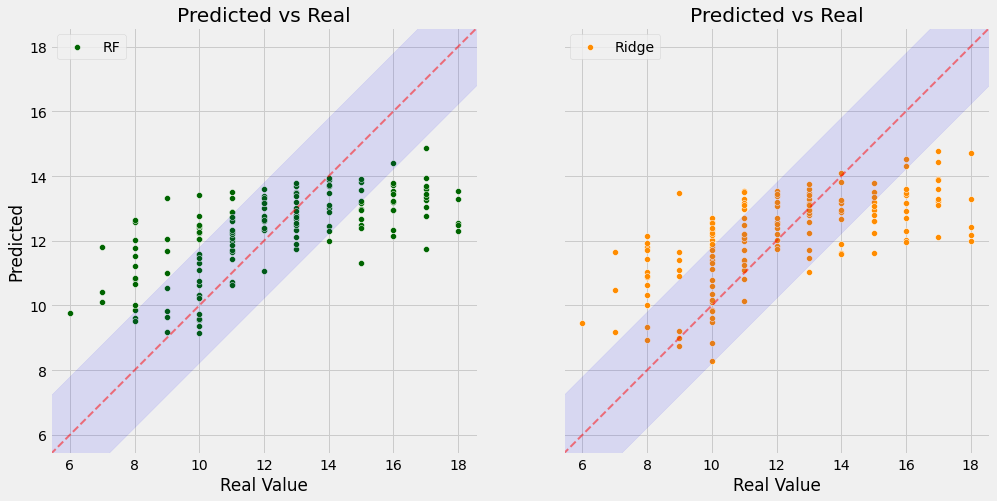

In [52]:
pred1 = rforest.predict(L_test)
pred2 = linear.predict(R_test)
# Scelgo il minor MAE
mae = mean_absolute_error(pred2, s_test)

# Scatterplot delle due predizioni
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,12))
sns.scatterplot(x=m_test, y=pred1, color="darkgreen", label="RF", ax=ax[0])
sns.scatterplot(x=s_test, y=pred2, color="darkorange", label="Ridge", ax=ax[1])
# Confronto con la retta y=x
for i in (0,1):
    lims = [np.min([ax[i].get_xlim(), ax[i].get_ylim()]), np.max([ax[i].get_xlim(), ax[i].get_ylim()])]
# Faccio un "fill" dell'area compresa tra +-MAE
    lims_shift_dx = [
    np.min([ax[i].get_xlim(), ax[i].get_ylim()])+mae,  
    np.max([ax[i].get_xlim(), ax[i].get_ylim()])+mae,  
    ]

    lims_shift_sx = [
    np.min([ax[i].get_xlim(), ax[i].get_ylim()])-mae,  
    np.max([ax[i].get_xlim(), ax[i].get_ylim()])-mae,  
    ]


    ax[i].plot(lims, lims, color='red', linewidth=2, alpha=0.5, linestyle='--')
    ax[i].fill_between(lims, lims_shift_sx, lims_shift_dx, edgecolor='none',
                     color='blue', alpha=0.1)
    ax[i].set_aspect('equal')
    ax[i].set_xlim(lims)
    ax[i].set_ylim(lims)
    ax[i].set_ylabel("Predicted")
    ax[i].set_xlabel("Real Value")
    ax[i].set_title("Predicted vs Real")

plt.show()

<a id="Oss3.3"></a>
### Osservazione 3.3


* Le predizioni fatte sono decisamente più valide rispetto al SVR;
* In entrambi i modelli si tende ad:
    - *overstimare* i voti dal 6 al 10 (ovvero a predire con voti più alti rispetto a quelli reali - ciò coincide con i punti sopra la bisettrice);
    - *understimare* i voti dal 15 al 18 (stesso discorso alla rovescia);
* La *Ridge* sembra fare leggermente meglio, anche solo ad occhio contando i pallini dentro l'area azzurra.

<a id="GBR"></a>
### GradientBoostingRegressor


L'idea del *GradientBoostingRegressor* è molto simile alla *Random Forest*, la differenza significativa sta nel come vengono validati i vari DT ed il peso di ciascuna features!

Iperparametri:
* learning_rate: rappresenta il "peso" da dare ad ogni DT. Di fondamentale importanza in quanto l'errore di ogni albero influisce sulla costruzione del successivo;
* max_depth: massima profondità dei *Decision Tree*, ovvero quanto "in basso" possiamo sviluppare il nostro albero;
* n_estimators: numero di DT da costruire e considerare/validare;
* min_samples_split: numero minimo di dati per poter dividere un nodo (altrimenti sarà una foglia);
* min_impurity_decrease: rappresenta una sorta di "soglia" grazie alla quale è possibile "potare" i vari rami dei DT.

In [53]:
params = {"n_estimators": np.arange(200, 500, 10),
    "max_depth": np.arange(4, 20, 1),
    "min_samples_split": np.arange(2, 10, 2),
    "learning_rate": np.arange(0.01, 0.6, 0.01),
    "min_impurity_decrease": np.arange(0, 100, 1)}

# Randomized con Lasso Features
xgb1 = RandomizedSearchCV(GradientBoostingRegressor(), params, n_iter=20, random_state=0, scoring='neg_root_mean_squared_error')
searchxl = xgb1.fit(L_train, m_train)
searchxl.best_params_

{'n_estimators': 260,
 'min_samples_split': 6,
 'min_impurity_decrease': 13,
 'max_depth': 5,
 'learning_rate': 0.15000000000000002}

In [54]:
# Errore
gbr_lasso = searchxl.best_estimator_
gbr_lasso.fit(L_train, m_train)
print_error(gbr_lasso, L_test, m_test, 'XGBR - Lasso Features')

MAE: 1.8717045775708645, RMSE: 2.342014841151078


In [55]:
# Randomized con RF Features
xgb2 = RandomizedSearchCV(GradientBoostingRegressor(), params, n_iter=20, random_state=0, scoring='neg_root_mean_squared_error')
searchxr = xgb2.fit(R_train, s_train)
searchxr.best_params_

{'n_estimators': 310,
 'min_samples_split': 6,
 'min_impurity_decrease': 18,
 'max_depth': 15,
 'learning_rate': 0.35000000000000003}

In [56]:
# Errore
gbr_rf = searchxr.best_estimator_
gbr_rf.fit(R_train, s_train)
print_error(gbr_rf, R_test, s_test, 'XGBR - RF Features')

MAE: 1.885113444239406, RMSE: 2.3653822958271506


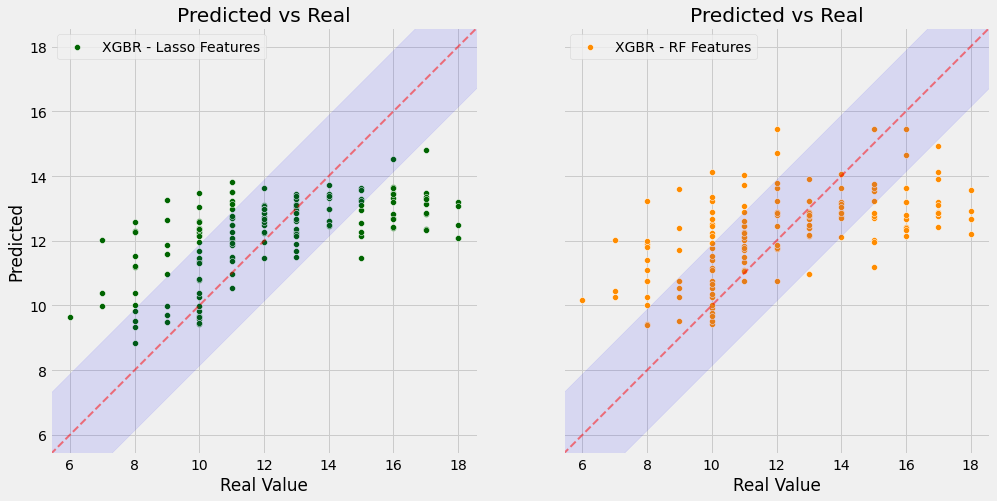

In [57]:
pred1 = gbr_lasso.predict(L_test)
pred2 = gbr_rf.predict(R_test)
# Scelgo il minor MAE
mae = mean_absolute_error(pred1, m_test)

# Scatterplot delle due predizioni
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,12))
sns.scatterplot(x=m_test, y=pred1, color="darkgreen", label="XGBR - Lasso Features", ax=ax[0])
sns.scatterplot(x=s_test, y=pred2, color="darkorange", label="XGBR - RF Features", ax=ax[1])
# Confronto con la retta y=x
for i in (0,1):
    lims = [np.min([ax[i].get_xlim(), ax[i].get_ylim()]), np.max([ax[i].get_xlim(), ax[i].get_ylim()])]
# Faccio un "fill" dell'area compresa tra +-MAE
    lims_shift_dx = [
    np.min([ax[i].get_xlim(), ax[i].get_ylim()])+mae,  
    np.max([ax[i].get_xlim(), ax[i].get_ylim()])+mae,  
    ]

    lims_shift_sx = [
    np.min([ax[i].get_xlim(), ax[i].get_ylim()])-mae,  
    np.max([ax[i].get_xlim(), ax[i].get_ylim()])-mae,  
    ]


    ax[i].plot(lims, lims, color='red', linewidth=2, alpha=0.5, linestyle='--')
    ax[i].fill_between(lims, lims_shift_sx, lims_shift_dx, edgecolor='none',
                     color='blue', alpha=0.1)
    ax[i].set_aspect('equal')
    ax[i].set_xlim(lims)
    ax[i].set_ylim(lims)
    ax[i].set_ylabel("Predicted")
    ax[i].set_xlabel("Real Value")
    ax[i].set_title("Predicted vs Real")

plt.show()

I risultati non si discostano poi molto dai due precedenti modelli.

---------------------

<a id="Con1"></a>
# Conclusione - Parte 1

In [58]:
print(tabulate(table, headers='keys', tablefmt='fancy_grid'))

╒═══════════════════════╤═════════╤═════════╕
│ Model                 │     MAE │    RMSE │
╞═══════════════════════╪═════════╪═════════╡
│ SVR - Lasso Features  │ 2.43224 │ 2.88018 │
├───────────────────────┼─────────┼─────────┤
│ SVR - RF Features     │ 2.42119 │ 2.86838 │
├───────────────────────┼─────────┼─────────┤
│ RF - Lasso Features   │ 1.82401 │ 2.27042 │
├───────────────────────┼─────────┼─────────┤
│ Ridge - RF Features   │ 1.78604 │ 2.23745 │
├───────────────────────┼─────────┼─────────┤
│ XGBR - Lasso Features │ 1.8717  │ 2.34201 │
├───────────────────────┼─────────┼─────────┤
│ XGBR - RF Features    │ 1.88511 │ 2.36538 │
╘═══════════════════════╧═════════╧═════════╛


Il miglior modello per la predizione dei voti, seguendo la tabella, è sicuramente la *Ridge Regression* con le RF features. Anche dal punto di vista computazionale, avendo meno iperparametri da validare (uno solo), è sicuramente preferibile.

Ricordiamo, inoltre, che la "classifica" delle fatures della RF vedeva le categorie Dalc e Walc rispettivamente al 9° e 14° posto, su un totale di 15. Il consumo di alcolici, dunque, ha un suo peso non irrilevante (soprattutto se considerassimo la somma dei due, in quanto l'effetto dell'alcol non si esaurisce nell'arco di un paio d'ore ma può avere anche effetti a lungo termine)!

<a id="Step4"></a>
# Step 4 - What if?


Cosa sarebbe successo se avessimo usato **tutte** le features presenti nel dataset per i nostri modelli?
Scopriamolo e vediamo gli errori che avremmo ottenuto rispetto al filtro sulle features effettuato!

In [59]:
# Controllo ci siano i dati giusti
print(features_imp.shape)
print(target_imp.shape)

features_imp.head()

(625, 97)
(625,)


,age,absences,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
0,1.178636,0.069205,1,0,1,0,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0
1,0.295366,-0.365501,1,0,1,0,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0
2,-1.471176,0.503912,1,0,1,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0
3,-1.471176,-0.800208,1,0,1,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
4,-0.587905,-0.800208,1,0,1,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1


In [60]:
X_train, X_test, y_train, y_test = train_test_split(features_imp, target_imp, random_state=10)

In [61]:
# Scelgo un insieme di parametri da validare
parameters = {'C' :  np.arange(5, 300, 1),
              'epsilon': np.arange(0.01, 5, 0.01),
              'gamma' : np.arange(0.01, 100, 0.01)}             
# Randomized SVR - all features
svr_all = RandomizedSearchCV(SVR(), parameters, n_iter=150, random_state=0, scoring='neg_root_mean_squared_error')
search_first = svr_all.fit(X_train, y_train)

In [62]:
svr_all = search_first.best_estimator_
search_first.fit(X_train, y_train)
print_error(svr_all, X_test, y_test, 'SVR - All Features')

MAE: 2.43549025670105, RMSE: 2.8839213305967517


In [63]:
# Random Forest

# Scelgo un insieme di parametri da validare
parameters = {'max_depth' :  np.arange(4, 20, 1),
              'n_estimators' : np.arange(200, 400, 10),
              'max_features' : np.arange(5, 30, 5),
              'min_samples_split' : np.arange(2, 10, 2)}
# Randomized 
rf_all = RandomizedSearchCV(RandomForestRegressor(), parameters, random_state=0, scoring='neg_root_mean_squared_error')
search_second = rf_all.fit(X_train, y_train)
search_second.best_params_

{'n_estimators': 340,
 'min_samples_split': 4,
 'max_features': 20,
 'max_depth': 18}

In [64]:
# Errore
rf_all = search_second.best_estimator_
rf_all.fit(X_train, y_train)
print_error(rf_all, X_test, y_test, 'RF - All Features')

MAE: 1.8293329632520499, RMSE: 2.2886908601578493


In [65]:
# Ridge

# Scelgo un insieme di parametri da validare
param = {'alpha': np.arange(0.01, 100, 0.01)}
# Randomized 
lin_regr = RandomizedSearchCV(Ridge(), param, random_state=0, n_iter=300, scoring='neg_root_mean_squared_error')
search_third = lin_regr.fit(X_train, y_train)
search_third.best_params_

{'alpha': 51.42}

In [66]:
# Errore
ridge_all = search_third.best_estimator_
ridge_all.fit(X_train, y_train)
print_error(ridge_all, X_test, y_test, 'Ridge - All Features')

MAE: 1.83554206959797, RMSE: 2.298585159920124


In [67]:
params = {"n_estimators": np.arange(200, 500, 10),
    "max_depth": np.arange(4, 20, 1),
    "min_samples_split": np.arange(2, 10, 2),
    "learning_rate": np.arange(0.01, 0.6, 0.01),
    "min_impurity_decrease": np.arange(0, 100, 1)}

# Randomized con All Features
xgb = RandomizedSearchCV(GradientBoostingRegressor(), params, n_iter=20, random_state=0, scoring='neg_root_mean_squared_error')
search_fourth = xgb.fit(X_train, y_train)
search_fourth.best_params_

{'n_estimators': 240,
 'min_samples_split': 6,
 'min_impurity_decrease': 37,
 'max_depth': 14,
 'learning_rate': 0.37}

In [68]:
# Errore
gbr_all = search_fourth.best_estimator_
gbr_all.fit(X_train, y_train)
print_error(gbr_all, X_test, y_test, 'XGBR - All Features')

MAE: 2.0177140045067405, RMSE: 2.4898451608950123


E se avessimo eliminato **tutte** le colonne con coefficiente pari a 0 nella Lasso?
Testiamola con il miglior modello.

In [69]:
df_dropped = features_imp.drop(columns=delete_in_what_if, axis=1)
df_dropped.head()

,age,absences,school_GP,school_MS,sex_F,Medu_1,Medu_4,Fedu_1,Mjob_at_home,reason_course,...,higher_no,internet_no,internet_yes,famrel_4,freetime_2,goout_2,goout_5,Dalc_1,Walc_4,health_5
0,1.178636,0.069205,1,0,1,0,1,0,1,1,...,0,1,0,1,0,0,0,1,0,0
1,0.295366,-0.365501,1,0,1,1,0,1,1,1,...,0,0,1,0,0,0,0,1,0,0
2,-1.471176,0.503912,1,0,1,1,0,1,1,0,...,0,0,1,1,0,1,0,0,0,0
3,-1.471176,-0.800208,1,0,1,0,1,0,0,0,...,0,0,1,0,1,1,0,1,0,1
4,-0.587905,-0.800208,1,0,1,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1


In [70]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df_dropped, target_imp, random_state=10)

In [71]:
# Ridge

# Scelgo un insieme di parametri da validare
param = {'alpha': np.arange(0.01, 100, 0.01)}
# Randomized 
lin_regr2 = RandomizedSearchCV(Ridge(), param, random_state=0, n_iter=300, scoring='neg_root_mean_squared_error')
search_third2 = lin_regr2.fit(X2_train, y2_train)
search_third2.best_params_

{'alpha': 16.12}

In [72]:
# Errore
ridge_all2 = search_third2.best_estimator_
ridge_all2.fit(X2_train, y2_train)
print_error(ridge_all2, X2_test, y2_test, 'Ridge - Only 28 Columns')

MAE: 1.787010624687149, RMSE: 2.215822672938624


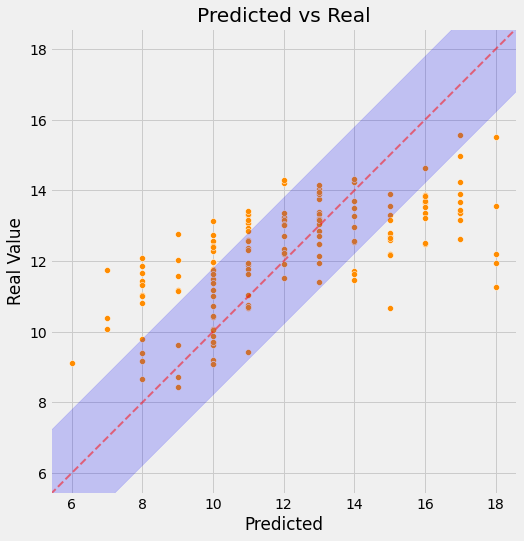

In [85]:
# Avendo ottenuto un RMSE minore, proviamo a vederlo graficamente!
pred1 = ridge_all2.predict(X2_test)
# Scelgo il minor MAE
mae = mean_absolute_error(pred1, y2_test)

# Scatterplot delle due predizioni
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x=y2_test, y=pred1, color="darkorange", ax=ax)
# Confronto con la retta y=x
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
]

lims_shift_dx = [
    np.min([ax.get_xlim(), ax.get_ylim()])+mae,  
    np.max([ax.get_xlim(), ax.get_ylim()])+mae,  
]

lims_shift_sx = [
    np.min([ax.get_xlim(), ax.get_ylim()])-mae,  
    np.max([ax.get_xlim(), ax.get_ylim()])-mae,  
]


ax.plot(lims, lims, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax.fill_between(lims, lims_shift_sx, lims_shift_dx, edgecolor='none',
                 color='blue', alpha=0.2)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Predicted")
ax.set_ylabel("Real Value")
ax.set_title("Predicted vs Real")
plt.show()

<a id="Con2"></a>
# Conclusione - Parte 2

In [73]:
print(tabulate(table, headers='keys', tablefmt='fancy_grid'))

╒═════════════════════════╤═════════╤═════════╕
│ Model                   │     MAE │    RMSE │
╞═════════════════════════╪═════════╪═════════╡
│ SVR - Lasso Features    │ 2.43224 │ 2.88018 │
├─────────────────────────┼─────────┼─────────┤
│ SVR - RF Features       │ 2.42119 │ 2.86838 │
├─────────────────────────┼─────────┼─────────┤
│ RF - Lasso Features     │ 1.82401 │ 2.27042 │
├─────────────────────────┼─────────┼─────────┤
│ Ridge - RF Features     │ 1.78604 │ 2.23745 │
├─────────────────────────┼─────────┼─────────┤
│ XGBR - Lasso Features   │ 1.8717  │ 2.34201 │
├─────────────────────────┼─────────┼─────────┤
│ XGBR - RF Features      │ 1.88511 │ 2.36538 │
├─────────────────────────┼─────────┼─────────┤
│ SVR - All Features      │ 2.43549 │ 2.88392 │
├─────────────────────────┼─────────┼─────────┤
│ RF - All Features       │ 1.82933 │ 2.28869 │
├─────────────────────────┼─────────┼─────────┤
│ Ridge - All Features    │ 1.83554 │ 2.29859 │
├─────────────────────────┼─────────┼───

A meno di rallentamenti nell'esecuzione del codice, i risultati sono *abbastanza* simili, e la *Ridge* si conferma come miglior modello in questo caso!

Il "rischio" - d'altro canto - è quello di aver scartato features che si sarebbero potute rivelare più utili, ma in termini di costi/risultato la nostra strada ha portato ad avere comunque dei risultati migliori.

--------

Eliminando tutte le features con coefficiente 0 della Lasso, invece, abbiamo ottenuto una predizione migliore!
La lista delle colonne è la seguente:

In [83]:
for i, col in enumerate(df_dropped.columns):
    print(f"Col: {col}  \t  \t  {ridge_all2.coef_[i]}")

Col: age  	  	  0.1820764960335397
Col: absences  	  	  -0.3061978703391634
Col: school_GP  	  	  0.34593273000923735
Col: school_MS  	  	  -0.34593273000923935
Col: sex_F  	  	  0.46131710682505284
Col: Medu_1  	  	  -0.17795114906117018
Col: Medu_4  	  	  0.628939169649168
Col: Fedu_1  	  	  -0.46409688879600014
Col: Mjob_at_home  	  	  -0.47438870173070097
Col: reason_course  	  	  -0.19296057838641398
Col: reason_reputation  	  	  0.13481644648708282
Col: studytime_1  	  	  -0.09760305946854675
Col: studytime_3  	  	  0.07003332595937051
Col: failures_0  	  	  1.7946754801547466
Col: schoolsup_no  	  	  0.3464570408481113
Col: schoolsup_yes  	  	  -0.34645704084811263
Col: activities_no  	  	  -0.14304546525697667
Col: activities_yes  	  	  0.14304546525697692
Col: higher_no  	  	  -0.8696785416187284
Col: internet_no  	  	  -0.1412396588525825
Col: internet_yes  	  	  0.141239658852583
Col: famrel_4  	  	  0.4170233887548916
Col: freetime_2  	  	  0.5614146544834113
Col: goout_2  

<a id="epilogo"></a>
## Idee iniziali vs Considerazioni finali

Possiamo fare un confronto con quanto detto in [Osservazione 1.7](#Oss1.7) e le features ricavate dai due metodi ([Lasso Features](#lasso) e [RF Features](#rafo)):

* Confermata la presenza di Dalc e Walc;
* Il tipo di lavoro (Mjob ed Fjob) è stato eliminato, nonostante avessimo sottolineato dei cambiamenti significativi con due categorie specifiche;
* Confermati il livello di istruzione (Medu e Fedu);
* Smentita l'ipotesi per cui il tempo libero fosse poco importante, persino il tempo dedicato allo studio ha un suo peso;
* Nonostante la rimozione degli *outliers* per l'età, anche questa feature è stata una di quelle confermate dai due modelli;
* Smentita l'ipotesi per cui le assenze (absences) non siano importanti a livello predittivo. Per la RF rappresenta addirittura la seconda feature per importanza!

-------------

Per quanto riguarda, invece, le features della Ridge con 28 colonne:

* Dalc_1 e Walc_4 sono le uniche features presenti relative al consumo di alcol, notiamo in particolare che:
    - Dalc_1 ha coefficiente positivo, dunque consumare meno alcol **aumenta** il voto finale;
    - Walc_4, viceversa, negativo, dunque fa **diminuire** il voto finale;
* Mjob_at_home: la nostra ipotesi era quindi corretta in realtà! Il fatto che la madre stia a casa influisce (negativamente) sul voto finale. Non è però presente neanche qua il Fjob_teacher.
* Ulteriore conferma per il livello di istruzione dei genitori:
    - Medu_1 e Fedu_1 hanno coefficiente negativo;
    - Medu_4 coefficiente positivo;
* Il tempo dedicato allo studio ha coefficienti vicini allo 0 (studytime_1 e 3). Presente, invece, freetime_2 che risulta essere una feature importante, al contrario di quanto anticipato inizialmente;
* Age ed absences rispettivamente con coefficiente positivo e negativo. Dunque all'aumentare delle assenze il voto finale diminuisce, viceversa per l'età.
* failures_0 ha un coefficiente di 1.79 (il maggiore tra tutti), ciò sottolinea l'importanza di non aver lasciato debiti durante l'anno!